In [2]:
import pandas as pd
import numpy as np
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
import matplotlib.pyplot as plt
import seaborn as sns
import cufflinks
cufflinks.go_offline(connected=True)
init_notebook_mode(connected=True)
from sklearn.model_selection import cross_val_score
pd.set_option('display.max_row', 100)
pd.set_option('display.max_column', 310)

import warnings
warnings.filterwarnings('ignore')

In [3]:
train_x_eng_with_KNN_TSNE_KMean = pd.read_csv("train_x_eng_with_KNN_TSNE_KMean.csv")
test_x_eng_with_KNN_TSNE_Kmean = pd.read_csv("test_x_eng_with_KNN_TSNE_Kmean.csv")

train_y_class = pd.read_csv("train_y_class.csv")
train_y_label = pd.read_csv("train_y_label.csv")

Submission = pd.read_csv("sampleSubmission.csv")

In [4]:
drop_columns_KNN = train_x_eng_with_KNN_TSNE_KMean.loc[:,"KNN_Feature_1":"KNN_Feature_99"].columns
drop_columns_K_Mean = train_x_eng_with_KNN_TSNE_KMean.loc[:,"Class_0":"cluster_space_8"].columns
drop_columns_all = train_x_eng_with_KNN_TSNE_KMean.loc[:,"KNN_Feature_1":"cluster_space_8"].columns
train_x_selected = train_x_eng_with_KNN_TSNE_KMean.drop(drop_columns_all,axis=1)
test_x_selected = test_x_eng_with_KNN_TSNE_Kmean.drop(drop_columns_all,axis=1)

In [5]:
from sklearn.preprocessing import StandardScaler
train_score_scaler = StandardScaler()
test_score_scaler = StandardScaler()
train_x_selected = pd.DataFrame(train_score_scaler.fit_transform(train_x_selected),columns = train_x_selected.columns)
test_x_selected = pd.DataFrame(test_score_scaler.fit_transform(test_x_selected),columns = test_x_selected.columns)

In [6]:
# Shuffle training data for neural network
train_y_class_columns = train_y_class.columns
train_x_selected_s = pd.concat([train_x_selected,train_y_class],axis=1)
train_x_selected_s = train_x_selected_s.sample(frac=1)

train_x_selected_NN = train_x_selected_s.drop(train_y_class_columns,axis=1)
train_x_selected_class = train_x_selected_s[train_y_class_columns]

In [7]:
# Total dataset features to consider
print(train_x_selected.shape)
print(train_x_selected_NN.shape)
print(test_x_selected.shape)

# Label dataset
print(train_x_selected_class.shape)
print(train_y_label.shape)

(61878, 100)
(61878, 100)
(144368, 100)
(61878, 9)
(61878, 1)


# 1. XGBoost Model, train_x_selected

In [8]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import pickle

In [9]:
# To track the iteration records for parameters tuning
best_score_list = []
best_params_list = []
best_R2_list = []

In [10]:
hyperparameters_tuning = {'learning_rate': [0.1],               # 6th when boosting
                          'gamma': [0,0.1,0.5],                       # 3rd
                          'max_depth': [6],                     # 1st to tune
                          'min_child_weight': [1,0,2],              # 2nd
                          'max_delta_step': [0],
                          'subsample': [0.7],                   # 4th
                          'colsample_bytree': [0.8],            # 4th 
                          'colsample_bylevel': [1],
                          'colsample_bynode': [1],
                          'reg_lambda': [0,0.5,1],                    # 5th
                          'reg_alpha': [0],                     # 5th
                          'scale_pos_weight': [1.0],            # only when dealing with imbalance classes
                          'n_estimators': [256],                # 1st
                          "booster": ["gbtree"],
                          "verbosity": [1],
                          "objective": ["multi:softprob"],
                          "eval_metric": ["mlogloss"],
                          "num_class": [9],
                          "seed": [0]
                         }                

In [11]:
# General Parameters setting inside Regressor
xgboost = xgb.XGBClassifier()

In [12]:
xgboost_grid = GridSearchCV(estimator = xgboost, param_grid = hyperparameters_tuning, cv = 4, iid = False)

In [ ]:
xgboost_grid.fit(train_x_selected,train_y_label)

In [ ]:
best_cv_score = xgboost_grid.cv_results_ #thus no need train-test split, as cv will automatic run for us 
best_params = xgboost_grid.best_params_
best_score = xgboost_grid.best_score_
best_rf = xgboost_grid.best_estimator_
best_accuracy_score = best_rf.score(train_x_selected,train_y_label)
best_score_list.append(best_score)
best_params_list.append(best_rf)
best_R2_list.append(best_accuracy_score)
print(best_score)
print(best_accuracy_score)
print(best_rf)

In [ ]:
print(best_score_list)
print(best_R2_list)
print(best_params_list)

# Create XGBoost's DMatrix, to boosting up the learning rate

In [31]:
trainDMat = xgb.DMatrix(data = train_x_selected, label = train_y_label)

In [32]:
# Lower the learning_rate and set a large num_boost_round hyperparameter to ensure convergence. 
# If convergence is slow, retry with a slightly higher learning rate (e.g. 0.075 instead of 0.05)
num_boost_round = 15000
early_stopping_rounds = 80
# Activates early stopping. CV error needs to decrease at least every <early_stopping_rounds> round(s) to continue.
# Last entry in evaluation history is the one from best iteration.

In [33]:
hyperparameters_boosting = {'learning_rate': 0.1,               # 6th when boosting
                          'gamma': 0,                       # 3rd
                          'max_depth': 6,                     # 1st to tune
                          'min_child_weight': 1,              # 2nd
                          'max_delta_step': 0,
                          'subsample': 0.7,                   # 4th
                          'colsample_bytree': 0.8,            # 4th 
                          'colsample_bylevel': 1,
                          'colsample_bynode': 1,
                          'reg_lambda': 0,                    # 5th
                          'reg_alpha': 0,                     # 5th
                          'scale_pos_weight': 1.0,            # only when dealing with imbalance classes
                          'n_estimators': 512,                # 1st
                          "booster": "gbtree",
                          "verbosity": 1,
                          "objective": "multi:softprob",
                          "eval_metric": "mlogloss",
                          "num_class": 9,
                          "seed": 0
                         }                

In [34]:
xgbCV = xgb.cv(
    params = hyperparameters_boosting, 
    dtrain = trainDMat, 
    num_boost_round = num_boost_round,
    nfold = 4, #same as CV
    metrics = {'merror'},
    early_stopping_rounds = early_stopping_rounds,
    verbose_eval = True,     
)

[0]	train-merror:0.333129+0.00696052	test-merror:0.343175+0.00824161
[1]	train-merror:0.283412+0.00451249	test-merror:0.293513+0.00772809
[2]	train-merror:0.266896+0.00290385	test-merror:0.278532+0.00311996
[3]	train-merror:0.258622+0.000711358	test-merror:0.269563+0.00281876
[4]	train-merror:0.253671+0.000574277	test-merror:0.264423+0.0031484
[5]	train-merror:0.249092+0.00148684	test-merror:0.259607+0.00200001
[6]	train-merror:0.245936+0.00126145	test-merror:0.257345+0.00187728
[7]	train-merror:0.243156+0.000750591	test-merror:0.255632+0.00241006
[8]	train-merror:0.240597+0.000642733	test-merror:0.25282+0.00259748
[9]	train-merror:0.239137+0.000352951	test-merror:0.251721+0.00221526
[10]	train-merror:0.237602+0.000395319	test-merror:0.250493+0.0027246
[11]	train-merror:0.236303+0.00035429	test-merror:0.249054+0.00288296
[12]	train-merror:0.234935+0.000236455	test-merror:0.248182+0.00283885
[13]	train-merror:0.233858+0.000284939	test-merror:0.246582+0.00222001
[14]	train-merror:0.23253

[116]	train-merror:0.163542+0.000564394	test-merror:0.201493+0.00210547
[117]	train-merror:0.163154+0.000552212	test-merror:0.201396+0.00208669
[118]	train-merror:0.162912+0.000529575	test-merror:0.201202+0.00214584
[119]	train-merror:0.162449+0.000552863	test-merror:0.200928+0.00188868
[120]	train-merror:0.162018+0.000718662	test-merror:0.200588+0.00189554
[121]	train-merror:0.161716+0.000526962	test-merror:0.20041+0.00195982
[122]	train-merror:0.161376+0.000766996	test-merror:0.200249+0.00207657
[123]	train-merror:0.161054+0.000687463	test-merror:0.200459+0.00212946
[124]	train-merror:0.160655+0.000701378	test-merror:0.200168+0.00232305
[125]	train-merror:0.160229+0.000580297	test-merror:0.199926+0.00212038
[126]	train-merror:0.159809+0.000479622	test-merror:0.1997+0.00230953
[127]	train-merror:0.159432+0.00046851	test-merror:0.199715+0.00226228
[128]	train-merror:0.159119+0.000461702	test-merror:0.199425+0.0024312
[129]	train-merror:0.158926+0.000435776	test-merror:0.199635+0.002321

[231]	train-merror:0.128107+0.000588214	test-merror:0.19052+0.00301855
[232]	train-merror:0.127897+0.000489192	test-merror:0.190633+0.00318449
[233]	train-merror:0.12766+0.000532535	test-merror:0.190649+0.00311414
[234]	train-merror:0.127542+0.000486716	test-merror:0.190633+0.00330484
[235]	train-merror:0.127256+0.000541011	test-merror:0.190326+0.00316021
[236]	train-merror:0.126976+0.000622356	test-merror:0.190374+0.00303715
[237]	train-merror:0.126685+0.000632056	test-merror:0.190245+0.00310738
[238]	train-merror:0.126534+0.000702377	test-merror:0.189971+0.00312766
[239]	train-merror:0.126313+0.000694698	test-merror:0.189922+0.00315327
[240]	train-merror:0.126071+0.000555228	test-merror:0.189728+0.0029963
[241]	train-merror:0.12578+0.000679922	test-merror:0.189825+0.00306599
[242]	train-merror:0.12565+0.000639082	test-merror:0.189809+0.00293645
[243]	train-merror:0.125527+0.000642765	test-merror:0.189744+0.00290005
[244]	train-merror:0.125192+0.000659614	test-merror:0.189793+0.002894

[346]	train-merror:0.103311+0.000561607	test-merror:0.186237+0.00322628
[347]	train-merror:0.103198+0.000537402	test-merror:0.186076+0.00325633
[348]	train-merror:0.102907+0.000386736	test-merror:0.18614+0.00321359
[349]	train-merror:0.102718+0.000382565	test-merror:0.186011+0.00347725
[350]	train-merror:0.102438+0.000381792	test-merror:0.185947+0.00346758
[351]	train-merror:0.102239+0.000353117	test-merror:0.185979+0.00341941
[352]	train-merror:0.102061+0.000373743	test-merror:0.186044+0.00334594
[353]	train-merror:0.101824+0.000232335	test-merror:0.185833+0.00347387
[354]	train-merror:0.101695+0.000250878	test-merror:0.18585+0.00350742
[355]	train-merror:0.101506+0.000365496	test-merror:0.185655+0.00354431
[356]	train-merror:0.101301+0.000242919	test-merror:0.185704+0.00364351
[357]	train-merror:0.10114+0.000303871	test-merror:0.185607+0.00355058
[358]	train-merror:0.101075+0.000326274	test-merror:0.185688+0.00346067
[359]	train-merror:0.100828+0.000311867	test-merror:0.185785+0.0036

[460]	train-merror:0.084128+0.000673915	test-merror:0.182957+0.00329658
[461]	train-merror:0.0838477+0.000736493	test-merror:0.182941+0.00346779
[462]	train-merror:0.0837187+0.000735164	test-merror:0.183005+0.00337845
[463]	train-merror:0.0835193+0.00060817	test-merror:0.182989+0.00332289
[464]	train-merror:0.083379+0.000573029	test-merror:0.182973+0.00330749
[465]	train-merror:0.083277+0.000606541	test-merror:0.182941+0.00338845
[466]	train-merror:0.083239+0.000684991	test-merror:0.183037+0.00339079
[467]	train-merror:0.0830453+0.000691116	test-merror:0.182989+0.0032851
[468]	train-merror:0.0828407+0.000663501	test-merror:0.183054+0.00330726
[469]	train-merror:0.082598+0.000562623	test-merror:0.183183+0.00327258
[470]	train-merror:0.0824365+0.000407678	test-merror:0.182973+0.00336191
[471]	train-merror:0.0822748+0.000452158	test-merror:0.182876+0.00336698
[472]	train-merror:0.0820915+0.000559285	test-merror:0.183151+0.00330199
[473]	train-merror:0.081887+0.000555916	test-merror:0.1830

[574]	train-merror:0.06794+0.000385846	test-merror:0.181615+0.00295469
[575]	train-merror:0.0678645+0.000436308	test-merror:0.181712+0.00301325
[576]	train-merror:0.0677032+0.000430183	test-merror:0.181648+0.00309005
[577]	train-merror:0.0675202+0.000532112	test-merror:0.181906+0.00337612
[578]	train-merror:0.067407+0.000490556	test-merror:0.181761+0.00326891
[579]	train-merror:0.0672615+0.00049838	test-merror:0.181777+0.00341283
[580]	train-merror:0.067218+0.000442279	test-merror:0.181729+0.00320458
[581]	train-merror:0.0670837+0.000394079	test-merror:0.181777+0.00301649
[582]	train-merror:0.0669975+0.00046334	test-merror:0.181599+0.00293699
[583]	train-merror:0.0668683+0.000517377	test-merror:0.181405+0.00294092
[584]	train-merror:0.0666795+0.000475046	test-merror:0.181551+0.00310777
[585]	train-merror:0.066658+0.000442499	test-merror:0.181486+0.00311243
[586]	train-merror:0.0663455+0.000423299	test-merror:0.181502+0.00310683
[587]	train-merror:0.0663077+0.000444443	test-merror:0.181

[688]	train-merror:0.0554532+0.000683594	test-merror:0.180419+0.00318702
[689]	train-merror:0.0553723+0.000625877	test-merror:0.180694+0.00325709
[690]	train-merror:0.0552375+0.000571178	test-merror:0.180517+0.00336576
[691]	train-merror:0.0551407+0.000537125	test-merror:0.180468+0.0033075
[692]	train-merror:0.0550542+0.000634075	test-merror:0.180403+0.00335046
[693]	train-merror:0.0549195+0.000619848	test-merror:0.180241+0.00335606
[694]	train-merror:0.0548552+0.000628663	test-merror:0.180436+0.00343045
[695]	train-merror:0.0548122+0.00053914	test-merror:0.180387+0.00331134
[696]	train-merror:0.054656+0.000533897	test-merror:0.180274+0.00318918
[697]	train-merror:0.0545163+0.000450971	test-merror:0.18029+0.00310636
[698]	train-merror:0.0543865+0.000507027	test-merror:0.180387+0.0030576
[699]	train-merror:0.0543435+0.000480756	test-merror:0.180322+0.00314476
[700]	train-merror:0.054295+0.000498711	test-merror:0.180387+0.00309553
[701]	train-merror:0.054214+0.000465203	test-merror:0.180

[801]	train-merror:0.045778+0.00043432	test-merror:0.17945+0.00326421
[802]	train-merror:0.0456435+0.00042636	test-merror:0.179288+0.00326826
[803]	train-merror:0.045563+0.000402226	test-merror:0.179256+0.00319702
[804]	train-merror:0.0455412+0.000370101	test-merror:0.179224+0.00310119
[805]	train-merror:0.045541+0.000422692	test-merror:0.179207+0.00298142
[806]	train-merror:0.0454495+0.000428498	test-merror:0.17924+0.0030881
[807]	train-merror:0.0454065+0.000394483	test-merror:0.179288+0.0031732
[808]	train-merror:0.0452987+0.000355515	test-merror:0.179191+0.00306582
[809]	train-merror:0.0452503+0.00038161	test-merror:0.179191+0.0031516
[810]	train-merror:0.0451695+0.000399116	test-merror:0.179127+0.00314456
[811]	train-merror:0.0450833+0.000403093	test-merror:0.179192+0.00329959
[812]	train-merror:0.0449705+0.000421205	test-merror:0.179256+0.00315526
[813]	train-merror:0.0449+0.000381221	test-merror:0.179337+0.00315966
[814]	train-merror:0.0447548+0.000315893	test-merror:0.179369+0.0

[915]	train-merror:0.037434+0.0005585	test-merror:0.1789+0.00227213
[916]	train-merror:0.0373747+0.000503834	test-merror:0.178691+0.00227309
[917]	train-merror:0.0373152+0.000453113	test-merror:0.178674+0.00212583
[918]	train-merror:0.037116+0.000471251	test-merror:0.178642+0.00214223
[919]	train-merror:0.0371862+0.000467315	test-merror:0.178707+0.00212632
[920]	train-merror:0.0371752+0.000470257	test-merror:0.178901+0.00225961
[921]	train-merror:0.037143+0.000570441	test-merror:0.178917+0.00218156
[922]	train-merror:0.0370837+0.00058888	test-merror:0.178804+0.00225494
[923]	train-merror:0.0369977+0.000555862	test-merror:0.178933+0.00213507
[924]	train-merror:0.036933+0.000509675	test-merror:0.178723+0.00221922
[925]	train-merror:0.036852+0.000515636	test-merror:0.178593+0.00237756
[926]	train-merror:0.0367605+0.000504919	test-merror:0.178739+0.00257266
[927]	train-merror:0.036685+0.000551175	test-merror:0.178642+0.00256488
[928]	train-merror:0.0365775+0.000504213	test-merror:0.178868+

[1028]	train-merror:0.0306573+0.000419109	test-merror:0.178318+0.00236321
[1029]	train-merror:0.0305922+0.000420773	test-merror:0.178367+0.00239609
[1030]	train-merror:0.0305277+0.000398783	test-merror:0.178205+0.00246703
[1031]	train-merror:0.0305008+0.000374511	test-merror:0.178011+0.00249269
[1032]	train-merror:0.0304307+0.000361779	test-merror:0.178028+0.00244328
[1033]	train-merror:0.0303555+0.000345582	test-merror:0.17806+0.00246483
[1034]	train-merror:0.0303933+0.000397237	test-merror:0.178124+0.00240171
[1035]	train-merror:0.030291+0.000387936	test-merror:0.178125+0.00248879
[1036]	train-merror:0.0302152+0.000364812	test-merror:0.178157+0.00225889
[1037]	train-merror:0.0302098+0.000363717	test-merror:0.178141+0.00223876
[1038]	train-merror:0.0301292+0.000416427	test-merror:0.178189+0.00221931
[1039]	train-merror:0.0300863+0.00037979	test-merror:0.178222+0.00224075
[1040]	train-merror:0.0300102+0.000364067	test-merror:0.178189+0.00228871
[1041]	train-merror:0.0299298+0.000331387

[1140]	train-merror:0.0255882+0.000139904	test-merror:0.177656+0.00218513
[1141]	train-merror:0.0255503+0.000151841	test-merror:0.177494+0.00236843
[1142]	train-merror:0.0255395+0.000115407	test-merror:0.177608+0.00225944
[1143]	train-merror:0.0255447+0.0001903	test-merror:0.17764+0.00236142
[1144]	train-merror:0.0254587+0.000145147	test-merror:0.177624+0.00240949
[1145]	train-merror:0.025394+6.3726e-05	test-merror:0.17751+0.00246916
[1146]	train-merror:0.0253833+7.90645e-05	test-merror:0.177494+0.00240302
[1147]	train-merror:0.0253078+6.21022e-05	test-merror:0.177591+0.00252825
[1148]	train-merror:0.0252433+7.23373e-05	test-merror:0.177462+0.00246954
[1149]	train-merror:0.0251893+4.07577e-05	test-merror:0.177397+0.00239492
[1150]	train-merror:0.0251518+3.89639e-05	test-merror:0.177365+0.00251555
[1151]	train-merror:0.0251087+6.56749e-05	test-merror:0.177527+0.00238788
[1152]	train-merror:0.025071+0.00010846	test-merror:0.177494+0.00250163
[1153]	train-merror:0.0250492+6.56368e-05	test

# Finalise XGBoost Model

In [35]:
num_boost_round = len(xgbCV)

xgbFinal = xgb.train(
    params = hyperparameters_boosting, 
    dtrain = trainDMat, 
    num_boost_round = num_boost_round,
)

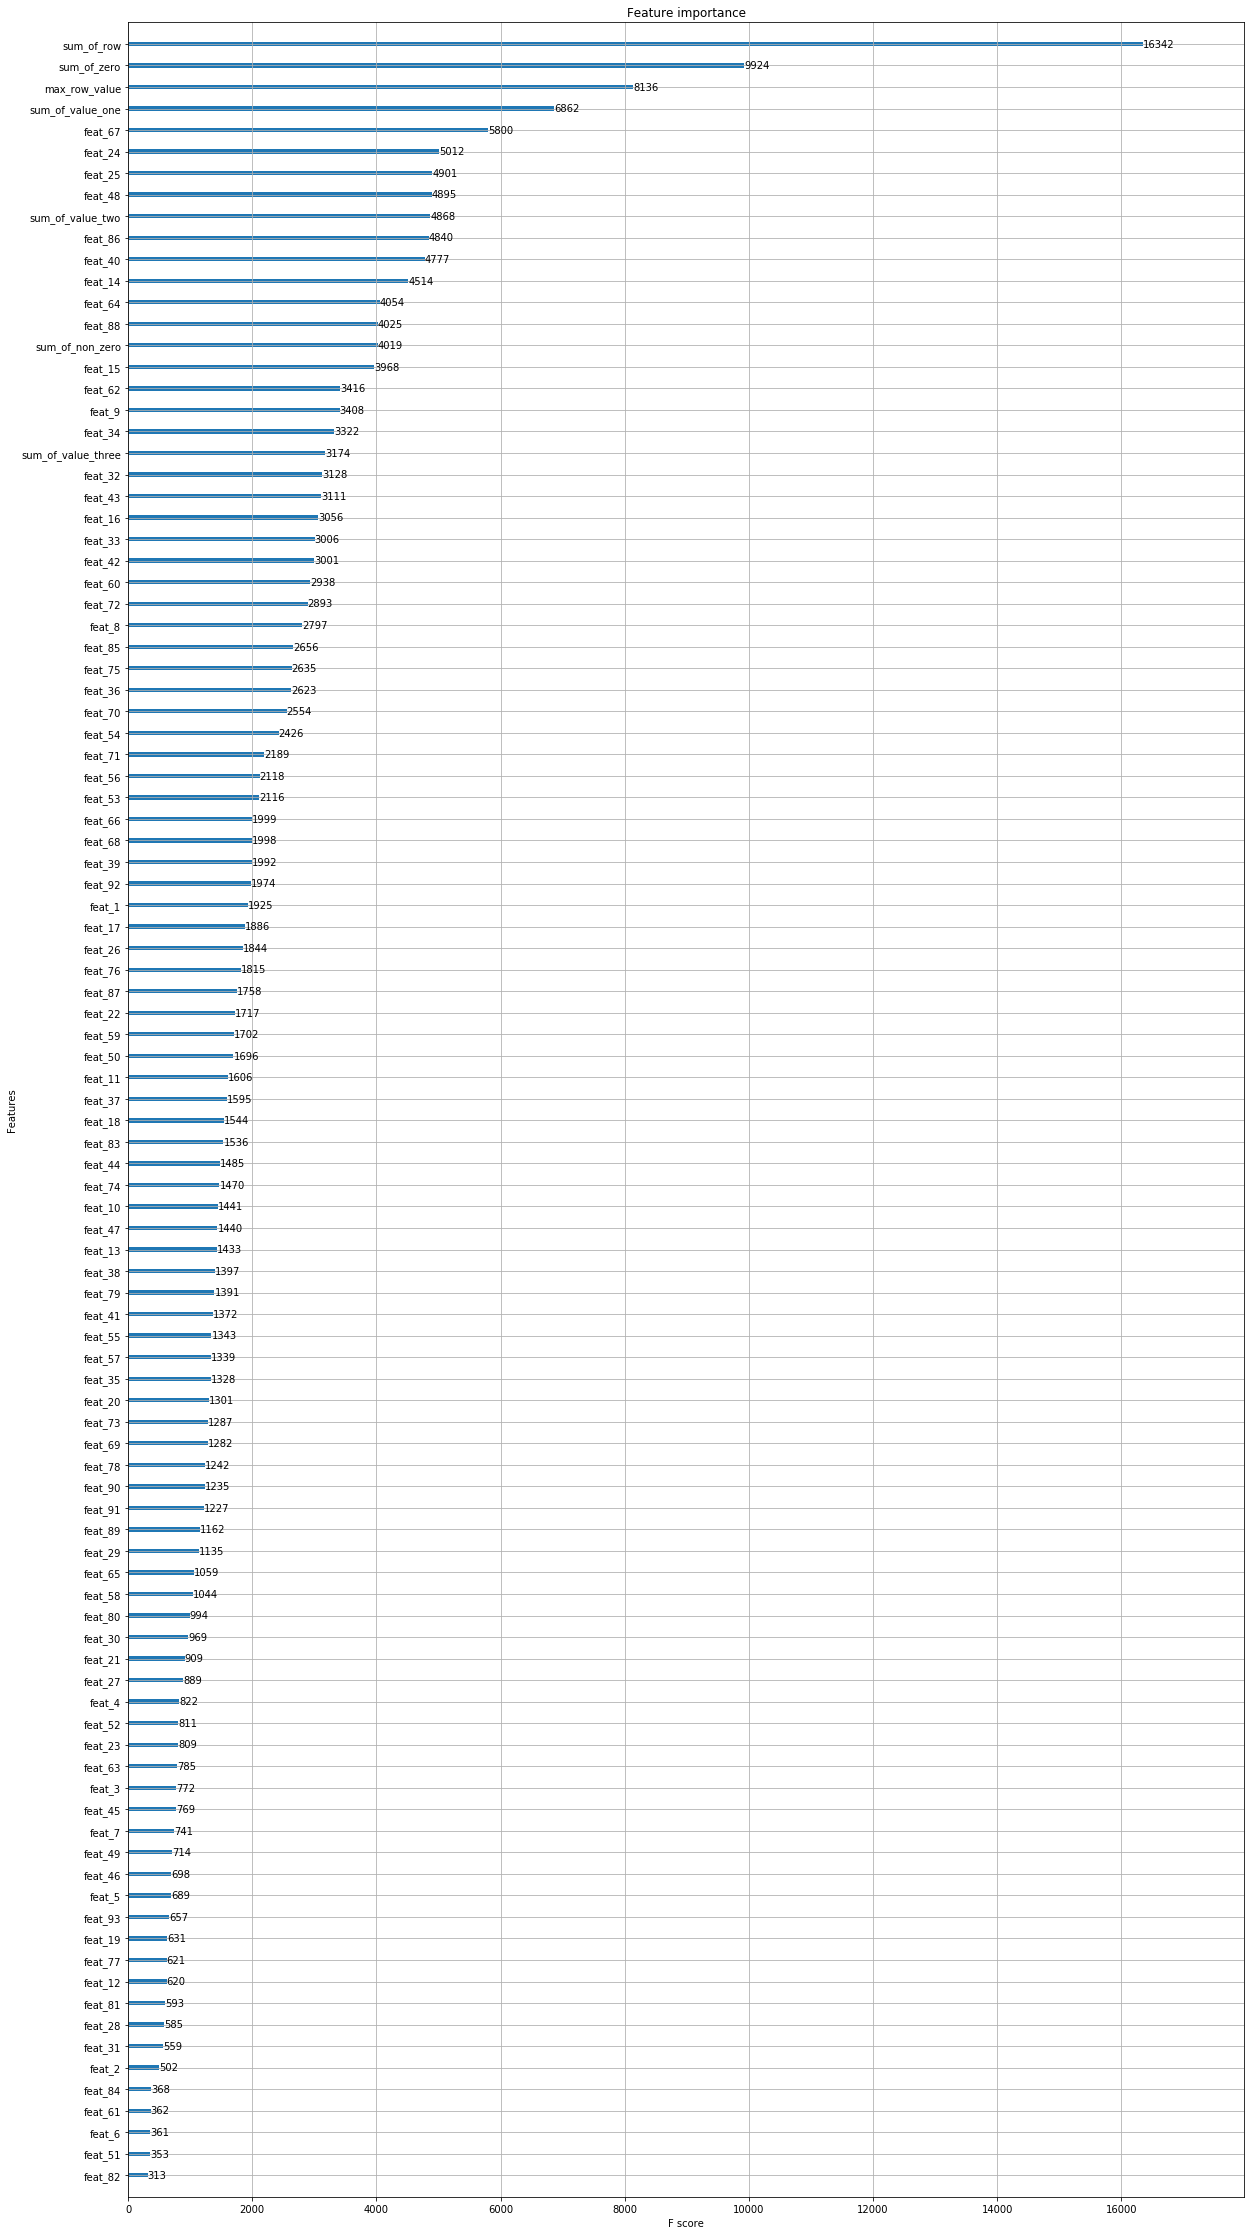

In [36]:
fig, ax = plt.subplots(figsize=(20, 40))
xgb.plot_importance(xgbFinal, ax=ax)

# XGBoost_test_x_all_included_pred_after boosting

In [37]:
XGBoost_test_x_selected_pred = xgbFinal.predict(xgb.DMatrix(test_x_selected))

In [38]:
Submission = pd.read_csv("sampleSubmission.csv")
Submission[['Class_1', 'Class_2', 'Class_3', 'Class_4', 'Class_5', 'Class_6',
       'Class_7', 'Class_8', 'Class_9']] = XGBoost_test_x_selected_pred

In [39]:
## Creating a Submission File to submit to Kaggle competition ##
Submission.to_csv("XGBoost_test_x_selected_pred.csv",index=False)

# Saving the final XGBoost model

In [ ]:
pickle.dump(xgbFinal, open("XGBoost_test_x_selected_pred_model.pickle.dat", "wb"))

# Loading the final XGBoost model

In [ ]:
XGBoost_test_x_selected_pred_model = pickle.load(open("XGBoost_test_x_selected_pred_model.pickle.dat", "rb"))

In [ ]:
# Re-forecast the prediction to verify the model
XGBoost_test_x_selected_pred = XGBoost_test_x_selected_pred_model.predict(xgb.DMatrix(test_x_selected))

# 2. Neural Network Model, train_x_selected

In [8]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Activation
from keras import regularizers
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping
import tensorflow as tf
print(keras.__version__)
print(tf.__version__)

Using TensorFlow backend.


2.2.5
1.13.1


## To have reproducible result with keras

In [9]:
# Seed value
# Apparently you may use different seed values at each stage
seed_value= 0
# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)
# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)
# 3. Set `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)
# 4. Set `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.set_random_seed(seed_value)
# 5. Configure a new global `tensorflow` session
from keras import backend
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
backend.set_session(sess)

# Neural Network Model

In [21]:
# define model
model = Sequential()
model.add(Dense(units=256,activation = "relu", input_dim=100))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(units=128,activation = "relu"))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(units=64,activation = "relu"))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(units=32,activation = "relu"))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(9, activation = "softmax"))

In [22]:
adam = keras.optimizers.Adam(lr=0.1, beta_1=0.9, beta_2=0.999, amsgrad=False, decay = 0.001)
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=50,baseline=None)
model.compile(optimizer=adam, loss='categorical_crossentropy') #loss = loss function
print(backend.eval(model.optimizer.lr)) # print model learning rate

0.1


In [23]:
model.fit(train_x_selected_NN,train_x_selected_class, validation_split = 0.05,
          batch_size=(int(train_x_selected_NN.shape[0]*0.2)),
          epochs=1000,verbose=1, callbacks=[early_stop])

Train on 58784 samples, validate on 3094 samples
Epoch 1/1000
58784/58784 [==============================] - 4s 63us/step - loss: 1.8963 - val_loss: 5.3087
Epoch 2/1000
58784/58784 [==============================] - 2s 39us/step - loss: 1.3259 - val_loss: 4.1068
Epoch 3/1000
58784/58784 [==============================] - 2s 42us/step - loss: 1.2113 - val_loss: 2.8988
Epoch 4/1000
58784/58784 [==============================] - 3s 43us/step - loss: 1.1476 - val_loss: 2.0589
Epoch 5/1000
58784/58784 [==============================] - 2s 41us/step - loss: 1.0988 - val_loss: 1.8641
Epoch 6/1000
58784/58784 [==============================] - 2s 39us/step - loss: 1.0553 - val_loss: 1.6544
Epoch 7/1000
58784/58784 [==============================] - 2s 37us/step - loss: 1.0246 - val_loss: 1.4468
Epoch 8/1000
58784/58784 [==============================] - 2s 36us/step - loss: 1.0007 - val_loss: 1.2136
Epoch 9/1000
58784/58784 [==============================] - 2s 41us/step - loss: 0.9809 - val_l

58784/58784 [==============================] - 2s 41us/step - loss: 0.5814 - val_loss: 0.5467
Epoch 152/1000
58784/58784 [==============================] - 2s 41us/step - loss: 0.5825 - val_loss: 0.5494
Epoch 153/1000
58784/58784 [==============================] - 2s 41us/step - loss: 0.5812 - val_loss: 0.5509
Epoch 154/1000
58784/58784 [==============================] - 2s 42us/step - loss: 0.5804 - val_loss: 0.5519
Epoch 155/1000
58784/58784 [==============================] - 2s 42us/step - loss: 0.5800 - val_loss: 0.5550
Epoch 156/1000
58784/58784 [==============================] - 2s 42us/step - loss: 0.5798 - val_loss: 0.5513
Epoch 157/1000
58784/58784 [==============================] - 2s 42us/step - loss: 0.5771 - val_loss: 0.5464
Epoch 158/1000
58784/58784 [==============================] - 2s 41us/step - loss: 0.5757 - val_loss: 0.5457
Epoch 159/1000
58784/58784 [==============================] - 2s 41us/step - loss: 0.5752 - val_loss: 0.5424
Epoch 160/1000
58784/58784 [======

58784/58784 [==============================] - 2s 41us/step - loss: 0.5261 - val_loss: 0.5188
Epoch 302/1000
58784/58784 [==============================] - 2s 41us/step - loss: 0.5278 - val_loss: 0.5159
Epoch 303/1000
58784/58784 [==============================] - 2s 41us/step - loss: 0.5239 - val_loss: 0.5139
Epoch 304/1000
58784/58784 [==============================] - 2s 40us/step - loss: 0.5223 - val_loss: 0.5151
Epoch 305/1000
58784/58784 [==============================] - 2s 39us/step - loss: 0.5246 - val_loss: 0.5187
Epoch 306/1000
58784/58784 [==============================] - 2s 39us/step - loss: 0.5241 - val_loss: 0.5163
Epoch 307/1000
58784/58784 [==============================] - 2s 40us/step - loss: 0.5246 - val_loss: 0.5153
Epoch 308/1000
58784/58784 [==============================] - 2s 40us/step - loss: 0.5228 - val_loss: 0.5139
Epoch 309/1000
58784/58784 [==============================] - 2s 41us/step - loss: 0.5236 - val_loss: 0.5146
Epoch 310/1000
58784/58784 [======

58784/58784 [==============================] - 2s 39us/step - loss: 0.4900 - val_loss: 0.4958
Epoch 452/1000
58784/58784 [==============================] - 2s 40us/step - loss: 0.4877 - val_loss: 0.4943
Epoch 453/1000
58784/58784 [==============================] - 2s 40us/step - loss: 0.4885 - val_loss: 0.4920
Epoch 454/1000
58784/58784 [==============================] - 2s 40us/step - loss: 0.4908 - val_loss: 0.5001
Epoch 455/1000
58784/58784 [==============================] - 2s 40us/step - loss: 0.4895 - val_loss: 0.4935
Epoch 456/1000
58784/58784 [==============================] - 2s 39us/step - loss: 0.4896 - val_loss: 0.4952
Epoch 457/1000
58784/58784 [==============================] - 2s 40us/step - loss: 0.4863 - val_loss: 0.4972
Epoch 458/1000
58784/58784 [==============================] - 2s 39us/step - loss: 0.4893 - val_loss: 0.4940
Epoch 459/1000
58784/58784 [==============================] - 2s 39us/step - loss: 0.4906 - val_loss: 0.4918
Epoch 460/1000
58784/58784 [======

58784/58784 [==============================] - 2s 35us/step - loss: 0.4614 - val_loss: 0.4851
Epoch 602/1000
58784/58784 [==============================] - 2s 35us/step - loss: 0.4641 - val_loss: 0.4901
Epoch 603/1000
58784/58784 [==============================] - 2s 36us/step - loss: 0.4616 - val_loss: 0.4846
Epoch 604/1000
58784/58784 [==============================] - 2s 36us/step - loss: 0.4605 - val_loss: 0.4859
Epoch 605/1000
58784/58784 [==============================] - 2s 36us/step - loss: 0.4619 - val_loss: 0.4865
Epoch 606/1000
58784/58784 [==============================] - 2s 36us/step - loss: 0.4618 - val_loss: 0.4865
Epoch 607/1000
58784/58784 [==============================] - 2s 35us/step - loss: 0.4628 - val_loss: 0.4876
Epoch 608/1000
58784/58784 [==============================] - 2s 35us/step - loss: 0.4632 - val_loss: 0.4862
Epoch 609/1000
58784/58784 [==============================] - 2s 35us/step - loss: 0.4597 - val_loss: 0.4854
Epoch 610/1000
58784/58784 [======

58784/58784 [==============================] - 2s 35us/step - loss: 0.4390 - val_loss: 0.4876
Epoch 752/1000
58784/58784 [==============================] - 2s 35us/step - loss: 0.4354 - val_loss: 0.4882
Epoch 753/1000
58784/58784 [==============================] - 2s 36us/step - loss: 0.4340 - val_loss: 0.4859
Epoch 00753: early stopping


# Visualization

In [24]:
loss_per_epoch = pd.DataFrame(model.history.history)
loss_per_epoch.iplot(y=["loss", "val_loss"], title = "loss_per_epoch")

# test_x Prediction for Ensemble Model

In [25]:
Neural_Network_test_x_selected_pred = pd.DataFrame(model.predict(test_x_selected))

In [26]:
Submission = pd.read_csv("sampleSubmission.csv")
Submission[['Class_1', 'Class_2', 'Class_3', 'Class_4', 'Class_5', 'Class_6',
       'Class_7', 'Class_8', 'Class_9']] = Neural_Network_test_x_selected_pred

In [27]:
## Creating a Submission File to submit to Kaggle competition ##
Submission.to_csv("Neural_Network_test_x_selected_pred.csv",index=False)

# Saving NN Models

In [28]:
model.save('Neural_Network_test_x_selected_pred_model.h5')

## Load NN model

In [ ]:
from keras.models import load_model
Load_model = load_model('Neural_Network_test_x_selected_pred_model.h5')

In [ ]:
Load_model.summary()

In [ ]:
Neural_Network_test_x_selected_pred = pd.DataFrame(Load_model.predict(test_x_selected))

In [ ]:
Submission = pd.read_csv("sampleSubmission.csv")
Submission[['Class_1', 'Class_2', 'Class_3', 'Class_4', 'Class_5', 'Class_6',
       'Class_7', 'Class_8', 'Class_9']] = Neural_Network_test_x_selected_pred

In [ ]:
## Creating a Submission File to submit to Kaggle competition ##
Submission.to_csv("Neural_Network_test_x_selected_pred.csv",index=False)

# Final Prediction, Weighted Average for XGBoost and Neural Network Prediction

In [14]:
NN_pred = pd.read_csv("Neural_Network_test_x_selected_pred.csv")
XGBoost_pred = pd.read_csv("XGBoost_test_x_selected_pred.csv")
XGBoost_tuned_pred = pd.read_csv("XGBoost_test_x_ensemble_tuned_pred.csv")

In [15]:
Weighted_Average_pred = (0.5*XGBoost_tuned_pred) + (0.2*XGBoost_pred) + (0.3*NN_pred)

In [16]:
Submission = pd.read_csv("sampleSubmission.csv")
Submission[['Class_1', 'Class_2', 'Class_3', 'Class_4', 'Class_5', 'Class_6',
       'Class_7', 'Class_8', 'Class_9']] = Weighted_Average_pred[['Class_1', 'Class_2', 'Class_3', 'Class_4', 'Class_5', 'Class_6',
       'Class_7', 'Class_8', 'Class_9']]

In [17]:
Submission.to_csv("Otto_Weighted_Average_Final_Pred.csv",index=False)